# Mava Quickstart Notebook



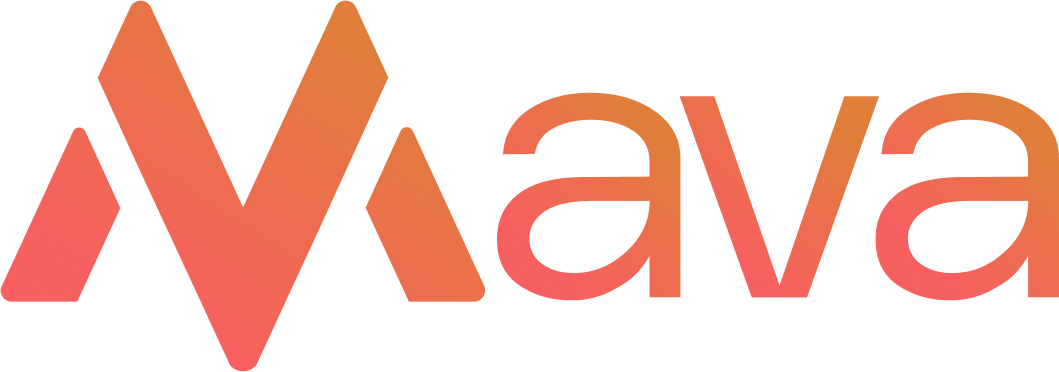

### This notebook offers a simple introduction to [Mava](https://github.com/instadeepai/Mava) by showing you how to build and train a multi-agent PPO (MAPPO) system in the RobotWarehouse environment from [Jumanji](https://github.com/instadeepai/jumanji). Mava follows the design philosophy of [CleanRL](https://github.com/vwxyzjn/cleanrl) allowing for easy code readability and reuse, and is built on top of code from [PureJaxRL](https://github.com/luchris429/purejaxrl), extending it to provide end-to-end JAX-based multi-agent algorithms.

<a href="https://colab.research.google.com/github/instadeepai/Mava/blob/develop/Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Requirements

We start by installing and importing the necessary packages.

> Note: Please anticipate a short delay while installing the requirements. Downgrading JAX to version `0.4.13` requires CUDA re-configuration for proper GPU detection in Colab. This setup may take a few minutes.

In [ ]:
%%capture
# @title Install Mava
! pip install git+https://github.com/instadeepai/mava.git@feat/pure-jax-mava
! pip install "jax[cuda12_pip]<=0.4.13" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Restarting the runtime is necessary after reinstalling JAX in Colab to ensure that the changes take effect and that the runtime environment is properly configured for the updated JAX version.

In [ ]:
# @title Restart Google Colab runtime
import os
os.kill(os.getpid(), 9)

In [ ]:
#@title Import required packages.

from typing import Any, Callable, Dict, Sequence, Tuple
from colorama import Fore, Style

import optax
from optax._src.base import OptState
import chex
import distrax
import flax.linen as nn
from flax import struct
from flax.core.frozen_dict import FrozenDict
from flax.linen.initializers import constant, orthogonal
import jax
import jax.numpy as jnp
import numpy as np

# Env requirements
import jumanji
from jumanji.env import Environment
from jumanji.environments.routing.robot_warehouse import Observation, State
from jumanji.environments.routing.robot_warehouse.generator import RandomGenerator
from jumanji import specs
from jumanji.wrappers import AutoResetWrapper

# Mava Helpful functions and types
from mava.utils.jax import merge_leading_dims
from mava.utils.timing_utils import TimeIt
from mava.wrappers.jumanji import (
    AgentIDWrapper,
    LogWrapper,
    ObservationGlobalState,
    RwareMultiAgentWithGlobalStateWrapper,
)
from mava.types import ExperimentOutput, LearnerState, PPOTransition
from mava.evaluator import evaluator_setup

# Plot requirements
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("white")
sns.color_palette("colorblind")
import time

# Trainer
This section encompasses the foundational methods required to set up the training process for MAPPO,


### Network

Initially, we construct the ActorCritic network using components from the Flax library. The application of the actor-critic's function will then be "vmapped" across distinct agents, with the `in_axes` parameter applied solely to the observation and not the network parameters. To learn more about `vmap` in JAX, please see the documentation [here](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html).

In [ ]:
class ActorCritic(nn.Module):
    """Actor Critic Network."""

    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, observation: Observation) -> Tuple[distrax.Categorical, chex.Array]:
        """Forward pass."""
        x = observation.agents_view

        actor_output = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(x)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            actor_output
        )
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_output)

        masked_logits = jnp.where(
            observation.action_mask,
            actor_output,
            jnp.finfo(jnp.float32).min,
        )
        actor_policy = distrax.Categorical(logits=masked_logits)

        y = observation.global_state

        critic_output = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(y)
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0))(
            critic_output
        )
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic_output
        )

        return actor_policy, jnp.squeeze(critic_output, axis=-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Learner Function
The `get_learner_fn` function returns a function which produces an `ExperimentOutput`, encapsulating updated learner state, episode information, and loss metrics.

In [ ]:
def get_learner_fn(
    env: jumanji.Environment, apply_fn: Callable, update_fn: Callable, config: Dict
) -> Callable:
    """Get the learner function."""

    def _update_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, Tuple]:
        """A single update of the network.

        This function steps the environment and records the trajectory batch for
        training. It then calculates advantages and targets based on the recorded
        trajectory and updates the actor and critic networks based on the calculated
        losses.

        Args:
            learner_state (NamedTuple):
                - params (FrozenDict): The current model parameters.
                - opt_state (OptState): The current optimizer state.
                - rng (PRNGKey): The random number generator state.
                - env_state (State): The environment state.
                - last_timestep (TimeStep): The last timestep in the current trajectory.
            _ (Any): The current metrics info.
        """

        def _env_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, PPOTransition]:
            """Step the environment."""
            params, opt_state, rng, env_state, last_timestep = learner_state

            # SELECT ACTION
            rng, policy_rng = jax.random.split(rng)
            actor_policy, value = apply_fn(params, last_timestep.observation)
            action = actor_policy.sample(seed=policy_rng)
            log_prob = actor_policy.log_prob(action)

            # STEP ENVIRONMENT
            env_state, timestep = jax.vmap(env.step, in_axes=(0, 0))(env_state, action)

            # LOG EPISODE METRICS
            done, reward = jax.tree_util.tree_map(
                lambda x: jnp.repeat(x, config["num_agents"]).reshape(config["num_envs"], -1),
                (timestep.last(), timestep.reward),
            )
            info = {
                "episode_return": env_state.episode_return_info,
                "episode_length": env_state.episode_length_info,
            }

            transition = PPOTransition(
                done, action, value, reward, log_prob, last_timestep.observation, info
            )
            learner_state = LearnerState(params, opt_state, rng, env_state, timestep)
            return learner_state, transition

        # STEP ENVIRONMENT FOR ROLLOUT LENGTH
        learner_state, traj_batch = jax.lax.scan(
            _env_step, learner_state, None, config["rollout_length"]
        )

        # CALCULATE ADVANTAGE
        params, opt_state, rng, env_state, last_timestep = learner_state
        _, last_val = apply_fn(params, last_timestep.observation)

        def _calculate_gae(
            traj_batch: PPOTransition, last_val: chex.Array
        ) -> Tuple[chex.Array, chex.Array]:
            """Calculate the GAE."""

            def _get_advantages(gae_and_next_value: Tuple, transition: PPOTransition) -> Tuple:
                """Calculate the GAE for a single transition."""
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                delta = reward + config["gamma"] * next_value * (1 - done) - value
                gae = delta + config["gamma"] * config["gae_lambda"] * (1 - done) * gae
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        def _update_epoch(update_state: Tuple, _: Any) -> Tuple:
            """Update the network for a single epoch."""

            def _update_minibatch(train_state: Tuple, batch_info: Tuple) -> Tuple:
                """Update the network for a single minibatch."""
                params, opt_state = train_state
                traj_batch, advantages, targets = batch_info

                def _loss_fn(
                    params: FrozenDict,
                    opt_state: OptState,
                    traj_batch: PPOTransition,
                    gae: chex.Array,
                    targets: chex.Array,
                ) -> Tuple:
                    """Calculate the loss."""
                    # RERUN NETWORK
                    actor_policy, value = apply_fn(params, traj_batch.obs)
                    log_prob = actor_policy.log_prob(traj_batch.action)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(
                        -config["clip_eps"], config["clip_eps"]
                    )
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config["clip_eps"],
                            1.0 + config["clip_eps"],
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    entropy = actor_policy.entropy().mean()

                    total_loss = (
                        loss_actor + config["vf_coef"] * value_loss - config["ent_coef"] * entropy
                    )
                    return total_loss, (value_loss, loss_actor, entropy)

                grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                loss_info, grads = grad_fn(params, opt_state, traj_batch, advantages, targets)

                # Compute the parallel mean (pmean) over the batch.
                # This calculation is inspired by the Anakin architecture demo notebook.
                # available at https://tinyurl.com/26tdzs5x
                # This pmean could be a regular mean as the batch axis is on the same device.
                grads, loss_info = jax.lax.pmean((grads, loss_info), axis_name="batch")
                # pmean over devices.
                grads, loss_info = jax.lax.pmean((grads, loss_info), axis_name="device")

                updates, new_opt_state = update_fn(grads, opt_state)
                new_params = optax.apply_updates(params, updates)

                return (new_params, new_opt_state), loss_info

            params, opt_state, traj_batch, advantages, targets, rng = update_state
            rng, shuffle_rng = jax.random.split(rng)

            # SHUFFLE MINIBATCHES
            batch_size = config["rollout_length"] * config["num_envs"]
            permutation = jax.random.permutation(shuffle_rng, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = jax.tree_util.tree_map(lambda x: merge_leading_dims(x, 2), batch)
            shuffled_batch = jax.tree_util.tree_map(
                lambda x: jnp.take(x, permutation, axis=0), batch
            )
            minibatches = jax.tree_util.tree_map(
                lambda x: jnp.reshape(x, [config["num_minibatches"], -1] + list(x.shape[1:])),
                shuffled_batch,
            )

            # UPDATE MINIBATCHES
            (params, opt_state), loss_info = jax.lax.scan(
                _update_minibatch, (params, opt_state), minibatches
            )

            update_state = (params, opt_state, traj_batch, advantages, targets, rng)
            return update_state, loss_info

        update_state = (params, opt_state, traj_batch, advantages, targets, rng)

        # UPDATE EPOCHS
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config["ppo_epochs"]
        )

        params, opt_state, traj_batch, advantages, targets, rng = update_state
        learner_state = LearnerState(params, opt_state, rng, env_state, last_timestep)
        metric = traj_batch.info
        return learner_state, (metric, loss_info)

    def learner_fn(learner_state: LearnerState) -> ExperimentOutput:
        """Learner function.

        This function represents the learner, it updates the network parameters
        by iteratively applying the `_update_step` function for a fixed number of
        updates. The `_update_step` function is vectorized over a batch of inputs.

        Args:
            learner_state (NamedTuple):
                - params (FrozenDict): The initial model parameters.
                - opt_state (OptState): The initial optimizer state.
                - rng (chex.PRNGKey): The random number generator state.
                - env_state (LogEnvState): The environment state.
                - timesteps (TimeStep): The initial timestep in the initial trajectory.
        """

        batched_update_step = jax.vmap(_update_step, in_axes=(0, None), axis_name="batch")

        learner_state, (metric, loss_info) = jax.lax.scan(
            batched_update_step, learner_state, None, config["num_updates_per_eval"]
        )
        total_loss, (value_loss, loss_actor, entropy) = loss_info
        return ExperimentOutput(
            learner_state=learner_state,
            episodes_info=metric,
            total_loss=total_loss,
            value_loss=value_loss,
            loss_actor=loss_actor,
            entropy=entropy,
        )

    return learner_fn


### Learner Setup
The learner setup initializes components for training: the learner function, neural network, optimizer, environment, and states. It creates a function for learning, employs parallel processing over the cores for efficiency, and sets up initial states.

In [ ]:
def learner_setup(
    env: Environment, rngs: chex.Array, config: Dict
) -> Tuple[callable, ActorCritic, LearnerState]:
    """Initialise learner_fn, network, optimiser, environment and states."""
    # Get available TPU cores.
    n_devices = len(jax.devices())
    # Get number of actions and agents.
    num_actions = int(env.action_spec().num_values[0])
    num_agents = env.action_spec().shape[0]
    config["num_agents"] = num_agents
    # PRNG keys.
    rng, rng_p = rngs

    # Define network and optimiser.
    network = ActorCritic(num_actions)
    optim = optax.chain(
        optax.clip_by_global_norm(config["max_grad_norm"]),
        optax.adam(config["lr"], eps=1e-5),
    )

    # Initialise observation.
    obs = env.observation_spec().generate_value()
    # Select only obs for a single agent.
    init_x = ObservationGlobalState(
        agents_view=obs.agents_view[0],
        action_mask=obs.action_mask[0],
        global_state=obs.global_state,
        step_count=obs.step_count[0],
    )
    init_x = jax.tree_util.tree_map(lambda x: x[None, ...], init_x)

    # initialise params and optimiser state.
    params = network.init(rng_p, init_x)
    opt_state = optim.init(params)

    # Vmap network apply function over number of agents.
    vmapped_network_apply_fn = jax.vmap(
        network.apply,
        in_axes=(None, ObservationGlobalState(1, 1, None, 1)),
        out_axes=(1, 1),
    )

    # Get batched iterated update and replicate it to pmap it over cores.
    learn = get_learner_fn(env, vmapped_network_apply_fn, optim.update, config)
    learn = jax.pmap(learn, axis_name="device")

    # Broadcast params and optimiser state to cores and batch.
    broadcast = lambda x: jnp.broadcast_to(x, (n_devices, config["update_batch_size"]) + x.shape)
    params = jax.tree_map(broadcast, params)
    opt_state = jax.tree_map(broadcast, opt_state)

    # Initialise environment states and timesteps.
    rng, *env_rngs = jax.random.split(
        rng, n_devices * config["update_batch_size"] * config["num_envs"] + 1
    )
    env_states, timesteps = jax.vmap(env.reset, in_axes=(0))(
        jnp.stack(env_rngs),
    )

    # Split rngs for each core.
    rng, *step_rngs = jax.random.split(rng, n_devices * config["update_batch_size"] + 1)
    # Add dimension to pmap over.
    reshape_step_rngs = lambda x: x.reshape((n_devices, config["update_batch_size"]) + x.shape[1:])
    step_rngs = reshape_step_rngs(jnp.stack(step_rngs))
    reshape_states = lambda x: x.reshape(
        (n_devices, config["update_batch_size"], config["num_envs"]) + x.shape[1:]
    )
    env_states = jax.tree_util.tree_map(reshape_states, env_states)
    timesteps = jax.tree_util.tree_map(reshape_states, timesteps)

    init_learner_state = LearnerState(params, opt_state, step_rngs, env_states, timesteps)
    return learn, network, init_learner_state

# Rendering and logging tools

### Rendering
The `render_one_episode` function simulates and visualizes one episode from rolling out a trained MAPPO model that will be passed to the function using `params`.

In [ ]:
def render_one_episode(config, params, max_steps=100) -> None:
    """Rollout episdoes of a trained MAPPO."""
    # Create env
    env = jumanji.make(config["env_name"])
    env = RwareMultiAgentWithGlobalStateWrapper(env)

    # Create network
    num_actions = int(env.action_spec().num_values[0])
    network = ActorCritic(num_actions)
    apply_fn = jax.vmap(
    network.apply,
    in_axes=(None, ObservationGlobalState(0, 0, None, 0)),
    )

    reset_fn = jax.jit(env.reset)
    step_fn = jax.jit(env.step)
    states = []
    key = jax.random.PRNGKey(config["seed"])
    key, reset_key = jax.random.split(key)
    state, timestep = reset_fn(reset_key)
    states.append(state)
    episode_return = 0
    episode_length = 0
    while not timestep.last():
        key, action_key = jax.random.split(key)
        pi, _ = apply_fn(params, timestep.observation)

        if config["evaluation_greedy"]:
            action = pi.mode()
        else:
            action = pi.sample(seed=action_key)
        state, timestep = step_fn(state, action)
        states.append(state)
        episode_return+=timestep.reward
        episode_length+=1

    # Print out the results of the episode
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE RETURN: {episode_return}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE LENGTH:{episode_length}{Style.RESET_ALL}")

    # Limit the number of steps to record to the maximum number of steps
    steps=min([max_steps,len(states)-1])
    states=states[:steps]

    # Render the episode
    env.animate(states=states, interval=100, save_path="./rware.gif")

###Logging:
The `plot_performance` function visualizes the performance of the algorithm, this plot will be refreshed each time evaluation interval happens!

In [ ]:
def plot_performance(metrics, ep_returns, start_time):
      plt.figure(figsize=(8, 4))
      clear_output(wait=True)

      ep_returns.append(metrics.episodes_info["episode_return"].mean())
      # Plot the data
      plt.plot(np.linspace(0, (time.time()-start_time)/ 60.0, len(list(ep_returns))),list(ep_returns))
      plt.xlabel('Run Time [Minutes]')
      plt.ylabel('Episode Return')
      plt.title(f'Robotic Warehouse with 4 Agents')
      # Show the plot
      plt.show()
      return ep_returns

# Exeperiment Setup (function and Hyperparameters)


The experiment setup includes: defining the hyperparameters, creating environments, setting up the learner and evaluator, and initializing some variables for plotting and logging purposes.


####Config

We start the experiment setup by defining the config dictionary that represents a set of the various hyperparameters for the experiment.

The configuration encompasses established hyperparameters, yet due to the utilization of JAX in the implementation, certain hyperparameters may emerge with novel significance. Thus, here are the definitions for select questionable configurations:

`num_updates`: The number of updates to perform during the training. This parameter is used to control the frequency of gradient updates.

`num_envs`:  Number of vectorised environments per device. For instance, if set to 512, it implies 512 environments running at the same time.

`num_evaluation` and `num_eval_episodes`: The `num_evaluation` is the frequency of evaluation runs, while `num_eval_episode` is the duration of each evaluation instance.

In [ ]:
config = {
        "lr": 2.5e-4,
        "update_batch_size": 2,
        "rollout_length": 128,
        "num_updates": 1000,
        "num_envs": 512,
        "ppo_epochs": 4,
        "num_minibatches": 8,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_eps": 0.2,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "env_name": "RobotWarehouse-v0",
        "num_eval_episodes": 32,
        "num_evaluation": 80,
        "evaluation_greedy": False,
        "seed":42
    }

####Define Training and Evaluation environments

We use a series of wrappers to configure the training and evaluation environments, each with distinct purposes, described as follows:

`RwareMultiAgentWithGlobalStateWrapper`: This wrapper includes a global environment state to be used by the centralised critic. It's worth noting that since robotic warehouse does not have a global state, we create one by concatenating the observations of all agents.

`AutoResetWrapper`: This wrapper automatically resets the environment after a completed episode. Once a terminal state is attained, the state, observation, and step type are reset in readiness for subsequent interactions.

`LogWrapper`: This wrapper contributes to the logging process by capturing episode returns and lengths during the episode step invocation.

In [ ]:
# Create envs
env = jumanji.make(config["env_name"])
env = RwareMultiAgentWithGlobalStateWrapper(env)
env = AutoResetWrapper(env)
env = LogWrapper(env)
eval_env = jumanji.make(config["env_name"])
eval_env = RwareMultiAgentWithGlobalStateWrapper(eval_env)

####The Learner and Evaluator Setup



In [ ]:
# PRNG keys.
rng, rng_e, rng_p = jax.random.split(jax.random.PRNGKey(config["seed"]), num=3)

# Setup learner.
learn, network, learner_state = learner_setup(env, (rng, rng_p), config)

# Setup evaluator.
evaluator, _,(trained_params, eval_rngs) = evaluator_setup(
    eval_env=eval_env,
    rng_e=rng_e,
    network=network,
    params=learner_state.params,
    config=config,
    centralised_critic=True,
)

####Additional variables definition


In this section of the code, the total number of timesteps for the experiment is calculated, followed by the partitioning of the training timesteps into distinct intervals determined by the value of `num_evaluation`.

**Calculating Total Timesteps:**

To calculate the total timesteps, the following formula is used:
```
total_timesteps = n_devices
* num_updates
* rollout_length
* update_batch_size
* num_envs
```
- `n_devices` represents the number of JAX devices available, which is essential for parallel computation.
- `num_updates` is the total number of updates the training process will go through.
- `rollout_length` is the number of timesteps in each rollout.
- `update_batch_size` is the batch size used for each update.
- `num_envs` is the number of parallel environments used for data collection.

This computation yields the total count of timesteps that will be carried out throughout the complete training procedure. Consequently, the number of timesteps within each training interval is established as ```total_timesteps/num_evaluation```





In [ ]:
# Calculate total timesteps.
n_devices = len(jax.devices())
config["num_updates_per_eval"] = config["num_updates"] // config["num_evaluation"]
timesteps_per_training = (
    n_devices
    * config["num_updates_per_eval"]
    * config["rollout_length"]
    * config["update_batch_size"]
    * config["num_envs"]
)

# Run experiment for a total number of evaluations.
ep_returns=[]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Run Experiment

####Compilation




The code cell provided involves the compilation of the learner and evaluator.

**Compilation in JAX:**

[JAX](https://jax.readthedocs.io/en/latest/index.html) is a numerical computing library that emphasizes efficient execution on accelerators, such as GPUs and TPUs. One of its key features is the concept of "compilation." Compilation in JAX involves transforming Python functions into optimized machine code, resulting in significantly faster execution times. When a function is compiled in JAX, it is transformed into a form that can efficiently utilize hardware accelerators. For more details, please see the documentation [here](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions).


In [ ]:
# Compiling the learner and evaluator
with TimeIt(tag="COMPILATION", environment_steps=timesteps_per_training):
    # Compile the learner function to optimize performance during training.
    learn(learner_state)

# Compile the evaluator function
_ = evaluator(trained_params, eval_rngs)


/usr/local/lib/python3.10/dist-packages/distrax/_src/utils/jittable.py:66: DeprecationWarning: jax.xla is deprecated. Use jax.interpreters.xla
  jax.xla.abstractify(x)
/usr/local/lib/python3.10/dist-packages/distrax/_src/utils/jittable.py:66: DeprecationWarning: jax.xla is deprecated. Use jax.interpreters.xla
  jax.xla.abstractify(x)


COMPILATION: Elapsed time=79.94s, SPS=1.97e+04


/usr/local/lib/python3.10/dist-packages/distrax/_src/utils/jittable.py:66: DeprecationWarning: jax.xla is deprecated. Use jax.interpreters.xla
  jax.xla.abstractify(x)


####Execution & Run the experiment

Now that the code has been compiled using JAX, its execution will benefit from optimized performance. We will proceed to train the MAPPO algorithm on the `small-4ag-easy` scenario from RobotWarehouse. The experiment follows a cyclic pattern, transitioning from training to evaluation and back to training.

The training phase consists of performing 1000 updates. Each update utilizes 512 parallel environments, with a rollout of 128 steps per environment. The batch size is updated twice within each training iteration. This comprehensive process results in a total of 131 million timesteps utilized for training.

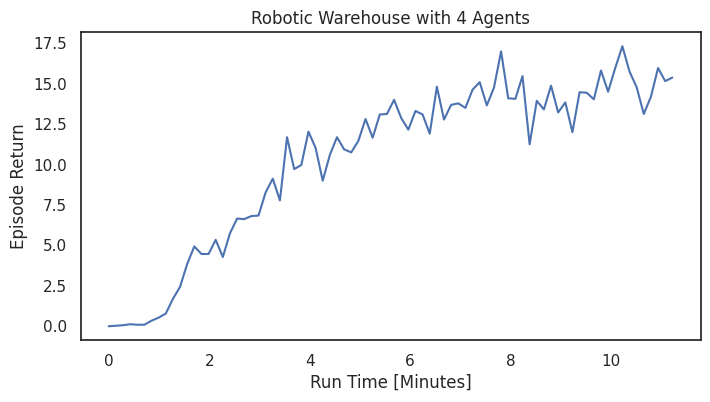

MAPPO experiment completed


In [ ]:
start_time=time.time()
for i in range(config["num_evaluation"]):
    # Train.
    with TimeIt(
        tag=("COMPILATION" if i == 0 else "EXECUTION"),
        environment_steps=timesteps_per_training,
    ):
        learner_output = learn(learner_state)
        jax.block_until_ready(learner_output)


    # Prepare for evaluation.
    trained_params = jax.tree_util.tree_map(
        lambda x: x[:, 0, ...], learner_output.learner_state.params
    )
    rng_e, *eval_rngs = jax.random.split(rng_e, n_devices + 1)
    eval_rngs = jnp.stack(eval_rngs)
    eval_rngs = eval_rngs.reshape(n_devices, -1)

    # Evaluate.
    evaluator_output = evaluator(trained_params, eval_rngs)
    jax.block_until_ready(evaluator_output)
    ep_returns=plot_performance(evaluator_output, ep_returns, start_time)

    # Update runner state to continue training.
    learner_state = learner_output.learner_state

# Return trained params to be used for rendering or testing.
trained_params= jax.tree_util.tree_map(
    lambda x: x[0, 0, ...], learner_output.learner_state.params
)
print(f"{Fore.CYAN}{Style.BRIGHT}MAPPO experiment completed{Style.RESET_ALL}")

####Rendering

Now let's render one episode using the trained system

> Note: Creating a complete episode animation can be time-consuming. To address this, we offer a parameter named `max_steps` for the `render_one_episode` function. This parameter determines the number of states displayed in the GIF. Please note that a full episode usually consists of 500 steps.

In [ ]:
render_one_episode(config, trained_params)

EPISODE RETURN: 18.0
EPISODE LENGTH:500


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


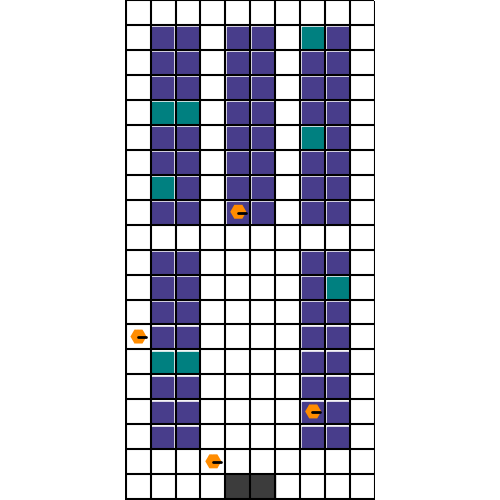

In [ ]:
import IPython
from IPython.display import Image
Image(filename='/content/rware.gif',embed=True)